In [5]:
''' Import libraries '''

import os, glob
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import math

from skimage import exposure
from scipy.ndimage.morphology import binary_erosion

In [6]:
''' Define useful functions '''

def get_mean(array):
    if array.size != 0: return array.mean()
    else: return math.nan

def get_std(array):
    if array.size != 0: return array.std()
    else: return math.nan

def get_median(array):
    if array.size != 0: return np.median(array)
    else: return math.nan

def erode_liver_3D(liver_array, voxel_dimensions):
    radius = 5
    x_dim = voxel_dimensions[0]
    y_dim = voxel_dimensions[1]
    z_dim = voxel_dimensions[2]
    kernel = np.zeros((2*int(math.ceil(radius/x_dim))+1, 2*int(math.ceil(radius/y_dim))+1, 2*int(math.ceil(radius/z_dim))+1))
    x,y,z = np.ogrid[-int(math.ceil(radius/x_dim)):int(math.ceil(radius/x_dim))+1, -int(math.ceil(radius/y_dim)):int(math.ceil(radius/y_dim))+1,-int(math.ceil(radius/z_dim)):int(math.ceil(radius/z_dim))+1]
    mask = ((x*x_dim)**2 + (y*y_dim)**2) + (z*z_dim)**2 <= radius**2
    kernel[mask] = 1
    eroded_liver = binary_erosion(liver_array, structure = kernel)

    return eroded_liver

In [97]:
''' Define case_id and mag, ff, and seg paths '''

case_id = 'c_1501.nii'

mag_path = r'N:\2_Analysis\automated_analysis\cynch_segmentations\mag_echo5'
ff_path = r'N:\2_Analysis\automated_analysis\cynch_segmentations\fatfrac'
#r2_path = r''
#seg_path = r'N:\2_Analysis\automated_analysis\flint_segmentations\whole_liver_segmentation'
seg_path = r'N:\2_Analysis\automated_analysis\lucy_segmentations\mark_liver_segs'

In [98]:
''' Load Nifti files and convert to numpy array '''

mag_ni = nib.load(os.path.join(mag_path, case_id))
ff_ni = nib.load(os.path.join(ff_path, case_id))
#r2_ni = nib.load(os.path.join(r2_path, case_id))
seg_ni = nib.load(os.path.join(seg_path, case_id))

mag = np.rot90(np.flip(mag_ni.get_fdata(), 0))
ff = np.rot90(np.flip(ff_ni.get_fdata(), 0))
#r2 = np.rot90(np.flip(r2_ni.get_fdata(), 0))
seg = np.rot90(np.flip(seg_ni.get_fdata(), 0))

print(mag.shape)
print(ff.shape)
#print(r2.shape)
print(seg.shape)

(224, 224, 30)
(224, 224, 30)
(224, 224, 30)


In [99]:
liver = seg
liver[seg != 1] = 0

print(liver.shape)

(224, 224, 30)


<function matplotlib.pyplot.show(close=None, block=None)>

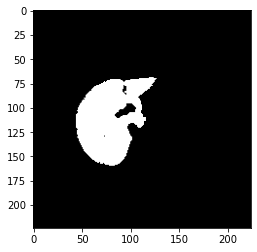

In [100]:
plt.imshow(liver[:,:,15],cmap='gray')
plt.show

In [101]:
seg = liver

In [102]:
''' Automatically Adjust Contrast '''

mag_level = np.zeros((mag.shape[0], mag.shape[1], mag.shape[2]))

for i in range(mag.shape[2]):
    img = mag[:,:,i]
    p2, p98 = np.percentile(img, (2, 98))
    mag_level[:,:,i] = exposure.rescale_intensity(img, in_range=(p2, p98))

<function matplotlib.pyplot.show(close=None, block=None)>

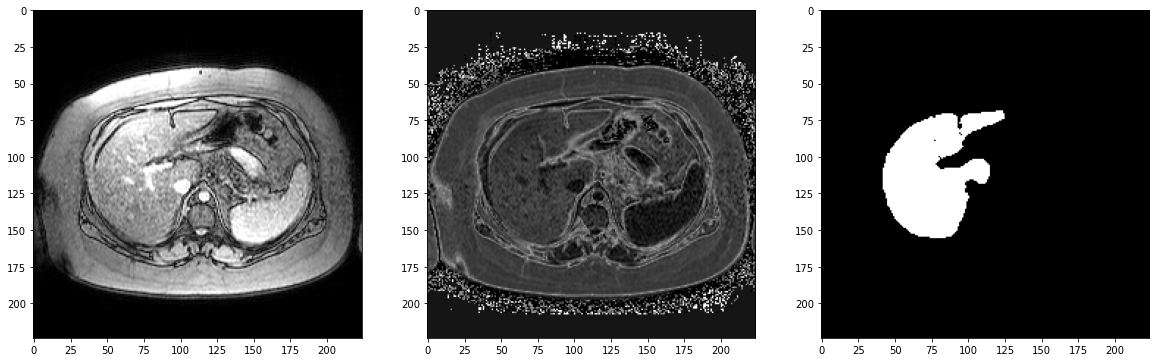

In [103]:
''' Plot Magnitude, FatFrac, and Segmentation '''

index = 14

fig = plt.figure(figsize=(20,15))
fig.add_subplot(1, 3, 1)
plt.imshow(mag_level[:,:,index],cmap='gray')
fig.add_subplot(1, 3, 2)
plt.imshow(ff[:,:,index],cmap='gray')
fig.add_subplot(1, 3, 3)
plt.imshow(seg[:,:,index],cmap='gray')
plt.show

In [104]:
''' Erode liver and calculate Volume and FatFrac and R2* '''

voxel_dimensions = (mag_ni.affine[0,0],mag_ni.affine[1,1],mag_ni.affine[2,2])
voxel_volume = voxel_dimensions[0] * voxel_dimensions[1] * voxel_dimensions[2]

eroded_liver = erode_liver_3D(seg, voxel_dimensions)

liv_ff = str(round(get_mean(ff[eroded_liver == 1]), 2))
#liv_r2 = str(get_mean(r2[eroded_liver == 1]))

liv_ff_mdn = str((np.median(ff[eroded_liver == 1])))
#liv_r2_mdn = str(np.median(r2[eroded_liver == 1]))

liv_ff_std = str(round(get_std(ff[eroded_liver == 1]),2))
#liv_r2_std = str(get_std(r2[eroded_liver == 1]))

liv_vol = str(round((seg.sum() * voxel_volume / 1000), 1))
n_voxels = str(seg.sum())

In [105]:
voxel_dimensions

(2.0982143878936768, 2.0982143878936768, 10.0)

In [106]:
print(case_id)
print('Liver Volume = ' + liv_vol + ' mL')
print('Number of Voxels = ' + n_voxels)
print('Liver FatFrac mean = ' + liv_ff + '%')
print('Liver FatFrac median = ' + liv_ff_mdn + '%')
print('Liver FatFrac StDev = ' + liv_ff_std)
#print('Liver R2* mean = ' + liv_r2)
#print('Liver R2* median = ' + liv_r2_mdn)
#print('Liver R2* StDev = ' + liv_r2_std)

c_1501.nii
Liver Volume = 2892.2 mL
Number of Voxels = 65695.0
Liver FatFrac mean = 17.27%
Liver FatFrac median = 18.0%
Liver FatFrac StDev = 5.42
